# Bladder Cancer

## Data processing

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

import shap
import lime
import json
from lime.lime_tabular import LimeTabularExplainer


# data load
df_BCa = pd.read_csv('BCa_raw.csv') # 암 원본 데이터 중 diagnosis 탭 data
df_BCa['Age'].fillna(df_BCa['Age'].mean(), inplace=True)

c:\Users\PC\anaconda3\envs\XAI_ML1\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\PC\anaconda3\envs\XAI_ML1\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [2]:
# 독립변수와 종속변수 정의

X_cb = df_BCa[['CK8','CK18','PD-1','PD-L1','Gender','Age']]

# diagnosis의 Y값 ('Decision')

Y = df_BCa['Decision']

# Column name의 list
col_name_cb = ['CK8','CK18','PD-1','PD-L1','Gender','Age']

# 독립변수(X) DataFrame 리스트
X_sets = [X_cb]

# 각 X 데이터셋의 이름
X_dataset_names = ['X_cb']

# 종속변수(y) Series 리스트
Y_sets = [Y]

# Col name 리스트
col_name_sets = [col_name_cb]

sets_name = ['cb']

num_sets = len(X_sets)

## Model.fit & predict

### 3) CatBoost

In [3]:
# CatBoost
from catboost import CatBoostClassifier

# model.fit
cb= CatBoostClassifier(learning_rate=0.005,iterations=10000)


# List에 4개의 cat model 담기
cb_classifiers = [cb]

- model.predict_proba

In [4]:
# 교차 검증(StratifiedKFold cross-validation) 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# results_proba_cb 딕셔너리 생성
results_cb = {}

# proba_result_cb
proba_cb = []

# Thresholds 설정 (0.1부터 0.7까지 0.05 간격으로 sweep)
thresholds = np.arange(0.1, 0.7, 0.05)

# ROC curve와 AUC 계산을 위한 빈 리스트 생성
roc_auc_list_cb = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]
fpr_list_cb = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]
tpr_list_cb = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]

best_threshold = 0.45


for i in range(num_sets):
    cm_total_cb = [0]*len(thresholds)
    acc_total_cb = [0]*len(thresholds)
    prec_total_cb = [0]*len(thresholds)
    rec_total_cb = [0]*len(thresholds)
    f1_total_cb = [0]*len(thresholds)
    auc_total_cb = [0]*len(thresholds)
    
    for num in range(len(thresholds)):
        cm_total_cb.append(np.zeros((2,2)))
        
    X_cb = X_sets[i].values
    Y_cb = Y_sets[i].values

    for j, (train_index, test_index) in enumerate(skf.split(X_cb, Y_cb)):
        X_train, X_test = X_cb[train_index], X_cb[test_index]
        Y_train, Y_test = Y_cb[train_index], Y_cb[test_index]

        cb_classifiers[i].fit(X_train, Y_train, eval_set=(X_test,Y_test), early_stopping_rounds=50,verbose=50)
        predictions_proba=cb_classifiers[i].predict_proba(X_test)[:,1]
        fold_results = list(zip(test_index,predictions_proba))
        proba_cb.append(fold_results)
        predictions_xai = (predictions_proba > best_threshold).astype(int)
        
        # 예측과 실제값이 다른 index 추출
        misclassified_indices = np.where(predictions_xai != Y_test)[0]
        misclassified_indices_test = test_index[predictions_xai != Y_test]
        print('잘못 예측한 index 번호 list',misclassified_indices_test)
        
        for index, index_test in zip(misclassified_indices, misclassified_indices_test):
            if i==0:
                print(f"SHAP Force Plot for misclassified data point {index_test} in set {i+1}:")
                print('index #',index_test,'의 실제 정답은',Y_sets[0][index_test],'예측 결과는',predictions_proba[index])
                # SHAP force plot 그리기
                explainer_cb = shap.TreeExplainer(cb_classifiers[0])
                shap_values_cb = explainer_cb.shap_values(X_sets[0].values)
                shap.initjs()
                # plt.figure()
                # Save SHAP force plot as an image file
                shap.force_plot(explainer_cb.expected_value, shap_values_cb[index_test], X_sets[0].iloc[index_test], show=False,matplotlib=True).savefig(f"cb_shap_plots/SHAP Force Plot for misclassified data point {index_test}.png")
                plt.close()

                # LIME table 그리기
                lime_explainer_1_cb = LimeTabularExplainer(X_sets[0].to_numpy(), feature_names=X_sets[0].columns.tolist(), class_names=['Not Decision', 'Decision'], verbose=True)
                lime_exp_1_cb = lime_explainer_1_cb.explain_instance(X_sets[0].iloc[index_test], cb_classifiers[0].predict_proba)
                # lime_exp_1_cb.show_in_notebook()
                # Save LIME table as an image file
                lime_exp_1_cb.save_to_file(f"cb_lime_plots/LIME table for misclassified data point {index_test}.html")
        
        
            
        for idx, threshold in enumerate(thresholds):
            predictions=(predictions_proba>threshold).astype(int)   # 확률을 이진 레이블로 변환
            # roc_curve 함수로 FPR (False Positive Rate)과 TPR (True Positive Rate) 계산
            fpr, tpr, thre = roc_curve(Y_test.astype(int), predictions_proba)
            # AUC 계산
            roc_auc = roc_auc_score(Y_test.astype(int), predictions_proba)
            fpr_list_cb[i][j] = fpr
            tpr_list_cb[i][j] = tpr
            roc_auc_list_cb[i][j][idx] = roc_auc
            cm_total_cb[idx]+=confusion_matrix(Y_test.astype(int),predictions)
            acc_total_cb[idx]+=accuracy_score(Y_test.astype(int),predictions)
            prec_total_cb[idx]+=precision_score(Y_test.astype(int),predictions)
            rec_total_cb[idx]+=recall_score(Y_test.astype(int),predictions)
            f1_total_cb[idx]+=f1_score(Y_test.astype(int), predictions)
            auc_total_cb[idx]+=roc_auc_score(Y_test.astype(int), predictions_proba)


            if f"Model {i+1}" not in results_cb:
                results_cb[f"Model {i+1}"]={}
                
            results_cb[f"Model {i+1}"][threshold]={
                "Confusion Matrix": cm_total_cb[idx],
                "Accuracy": acc_total_cb[idx] / skf.get_n_splits(),
                "Precision": prec_total_cb[idx] / skf.get_n_splits(),
                "Recall": rec_total_cb[idx] / skf.get_n_splits(),
                
                "F1-Score": f1_total_cb[idx] / skf.get_n_splits(),
                "AUC": auc_total_cb[idx] / skf.get_n_splits()
            }
        
            

# Predict_proba값 index 순서대로 정렬 후 저장          
sorted_result_cb = [0]
df_proba_cb = [0]
proba_cb = np.concatenate(proba_cb)
sorted_result_cb = proba_cb[proba_cb[:, 0].argsort()]
df_proba_cb = pd.DataFrame(sorted_result_cb[:,1], columns=['Predictor value'])
    
# csv로 저장
df_proba_cb.to_csv('Predictor value CB.csv', index=False)

0:	learn: 0.6897683	test: 0.6910322	best: 0.6910322 (0)	total: 128ms	remaining: 21m 19s
50:	learn: 0.5357020	test: 0.5970360	best: 0.5970360 (50)	total: 159ms	remaining: 31.1s
100:	learn: 0.4363745	test: 0.5394943	best: 0.5394943 (100)	total: 202ms	remaining: 19.8s
150:	learn: 0.3579868	test: 0.5030791	best: 0.5030791 (150)	total: 249ms	remaining: 16.2s
200:	learn: 0.3028346	test: 0.4748510	best: 0.4748510 (200)	total: 301ms	remaining: 14.7s
250:	learn: 0.2619669	test: 0.4599359	best: 0.4599359 (250)	total: 338ms	remaining: 13.1s
300:	learn: 0.2297675	test: 0.4493924	best: 0.4493924 (300)	total: 377ms	remaining: 12.2s
350:	learn: 0.2053727	test: 0.4376604	best: 0.4376604 (350)	total: 424ms	remaining: 11.7s
400:	learn: 0.1843638	test: 0.4329367	best: 0.4324799 (394)	total: 473ms	remaining: 11.3s
450:	learn: 0.1663605	test: 0.4314961	best: 0.4309440 (443)	total: 518ms	remaining: 11s
500:	learn: 0.1507255	test: 0.4273298	best: 0.4273298 (500)	total: 569ms	remaining: 10.8s
550:	learn: 0.13

Intercept 0.5823507108445282
Prediction_local [0.4927918]
Right: 0.23425897817432723
SHAP Force Plot for misclassified data point 62 in set 1:
index # 62 의 실제 정답은 0 예측 결과는 0.6940486602928987


Intercept 0.5128160828429663
Prediction_local [0.67660373]
Right: 0.6940486602928987
SHAP Force Plot for misclassified data point 82 in set 1:
index # 82 의 실제 정답은 0 예측 결과는 0.7750472178526563


Intercept 0.5182644249398027
Prediction_local [0.61003284]
Right: 0.7750472178526563
0:	learn: 0.6892305	test: 0.6923557	best: 0.6923557 (0)	total: 1.03ms	remaining: 10.3s
50:	learn: 0.5302429	test: 0.6376071	best: 0.6376071 (50)	total: 66.6ms	remaining: 13s
100:	learn: 0.4242565	test: 0.6118304	best: 0.6115252 (96)	total: 135ms	remaining: 13.3s
150:	learn: 0.3459740	test: 0.5900713	best: 0.5895247 (149)	total: 189ms	remaining: 12.4s
200:	learn: 0.2931157	test: 0.5824652	best: 0.5824652 (200)	total: 268ms	remaining: 13.1s
250:	learn: 0.2506884	test: 0.5843244	best: 0.5810251 (225)	total: 300ms	remaining: 11.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5810250545
bestIteration = 225

Shrink model to first 226 iterations.
잘못 예측한 index 번호 list [24 69 72]
SHAP Force Plot for misclassified data point 24 in set 1:
index # 24 의 실제 정답은 1 예측 결과는 0.4013435803833962


Intercept 0.7171525003840088
Prediction_local [0.27157504]
Right: 0.4013435803833962
SHAP Force Plot for misclassified data point 69 in set 1:
index # 69 의 실제 정답은 0 예측 결과는 0.4911902729518978


Intercept 0.5195813805469174
Prediction_local [0.51847909]
Right: 0.4911902729518978
SHAP Force Plot for misclassified data point 72 in set 1:
index # 72 의 실제 정답은 0 예측 결과는 0.8751085436592777


Intercept 0.44210334153530984
Prediction_local [0.72124375]
Right: 0.8751085436592777
0:	learn: 0.6906627	test: 0.6915509	best: 0.6915509 (0)	total: 1.9ms	remaining: 19s
50:	learn: 0.5425472	test: 0.5909366	best: 0.5909366 (50)	total: 66.1ms	remaining: 12.9s
100:	learn: 0.4382208	test: 0.5248846	best: 0.5248846 (100)	total: 122ms	remaining: 12s
150:	learn: 0.3671794	test: 0.4830263	best: 0.4830263 (150)	total: 166ms	remaining: 10.8s
200:	learn: 0.3159022	test: 0.4533231	best: 0.4533231 (200)	total: 214ms	remaining: 10.5s
250:	learn: 0.2745296	test: 0.4313427	best: 0.4313427 (250)	total: 288ms	remaining: 11.2s
300:	learn: 0.2400080	test: 0.4183085	best: 0.4183085 (300)	total: 322ms	remaining: 10.4s
350:	learn: 0.2139024	test: 0.4123663	best: 0.4122853 (348)	total: 354ms	remaining: 9.73s
400:	learn: 0.1926421	test: 0.4119332	best: 0.4112263 (390)	total: 384ms	remaining: 9.18s
450:	learn: 0.1743895	test: 0.4088810	best: 0.4076640 (438)	total: 413ms	remaining: 8.74s
Stopped by overfitting 

Intercept 0.743666027192951
Prediction_local [0.32923931]
Right: 0.22523983404574752
SHAP Force Plot for misclassified data point 56 in set 1:
index # 56 의 실제 정답은 0 예측 결과는 0.8276966449185664


Intercept 0.6720602337372041
Prediction_local [0.54285976]
Right: 0.8276966449185664
0:	learn: 0.6904217	test: 0.6892205	best: 0.6892205 (0)	total: 1.04ms	remaining: 10.4s
50:	learn: 0.5513415	test: 0.5668740	best: 0.5668740 (50)	total: 34ms	remaining: 6.64s
100:	learn: 0.4598685	test: 0.4863297	best: 0.4863297 (100)	total: 88ms	remaining: 8.63s
150:	learn: 0.3892038	test: 0.4250117	best: 0.4250117 (150)	total: 130ms	remaining: 8.47s
200:	learn: 0.3382589	test: 0.3888210	best: 0.3888210 (200)	total: 161ms	remaining: 7.85s
250:	learn: 0.2965518	test: 0.3583231	best: 0.3583231 (250)	total: 196ms	remaining: 7.63s
300:	learn: 0.2606267	test: 0.3306230	best: 0.3306230 (300)	total: 244ms	remaining: 7.86s
350:	learn: 0.2330189	test: 0.3135724	best: 0.3135724 (350)	total: 275ms	remaining: 7.55s
400:	learn: 0.2109371	test: 0.2994280	best: 0.2993758 (399)	total: 306ms	remaining: 7.32s
450:	learn: 0.1897910	test: 0.2902027	best: 0.2900786 (448)	total: 341ms	remaining: 7.22s
500:	learn: 0.1728910	

Intercept 0.7668894153474253
Prediction_local [0.5010378]
Right: 0.6722946255382974
SHAP Force Plot for misclassified data point 67 in set 1:
index # 67 의 실제 정답은 0 예측 결과는 0.5031868951866321


Intercept 0.5571363443834421
Prediction_local [0.7115069]
Right: 0.5031868951866321
SHAP Force Plot for misclassified data point 70 in set 1:
index # 70 의 실제 정답은 0 예측 결과는 0.5164939349267873


Intercept 0.5941906232710771
Prediction_local [0.60237548]
Right: 0.5164939349267873
0:	learn: 0.6904646	test: 0.6923195	best: 0.6923195 (0)	total: 1.04ms	remaining: 10.4s
50:	learn: 0.5506324	test: 0.5990872	best: 0.5990872 (50)	total: 37.9ms	remaining: 7.38s
100:	learn: 0.4551081	test: 0.5398327	best: 0.5398327 (100)	total: 88.6ms	remaining: 8.68s
150:	learn: 0.3852875	test: 0.4987936	best: 0.4987936 (150)	total: 141ms	remaining: 9.22s
200:	learn: 0.3331477	test: 0.4689605	best: 0.4689605 (200)	total: 203ms	remaining: 9.91s
250:	learn: 0.2929845	test: 0.4485238	best: 0.4485238 (250)	total: 245ms	remaining: 9.5s
300:	learn: 0.2623186	test: 0.4394398	best: 0.4394398 (300)	total: 281ms	remaining: 9.04s
350:	learn: 0.2353357	test: 0.4309631	best: 0.4304520 (346)	total: 322ms	remaining: 8.85s
400:	learn: 0.2096867	test: 0.4233646	best: 0.4233646 (400)	total: 371ms	remaining: 8.88s
450:	learn: 0.1908538	test: 0.4184927	best: 0.4184927 (450)	total: 402ms	remaining: 8.51s
500:	learn: 0.17405

Intercept 0.7947944866125995
Prediction_local [0.16067695]
Right: 0.23197168327038506
SHAP Force Plot for misclassified data point 51 in set 1:
index # 51 의 실제 정답은 1 예측 결과는 0.23618394185180538


Intercept 0.7108725985561352
Prediction_local [0.46942066]
Right: 0.23618394185180538


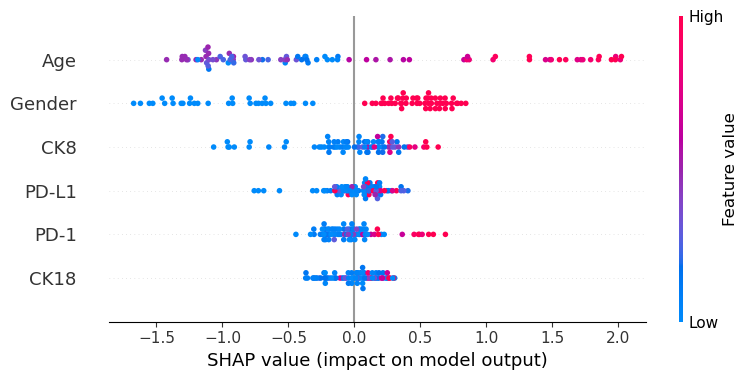

In [5]:
for i in range(num_sets):
    explainer_summary_cb = shap.TreeExplainer(cb_classifiers[i])
    shap_values_summary_cb = explainer_summary_cb.shap_values(X_sets[i].values,Y_sets[i].values)
    shap.summary_plot(shap_values_summary_cb, X_sets[i])

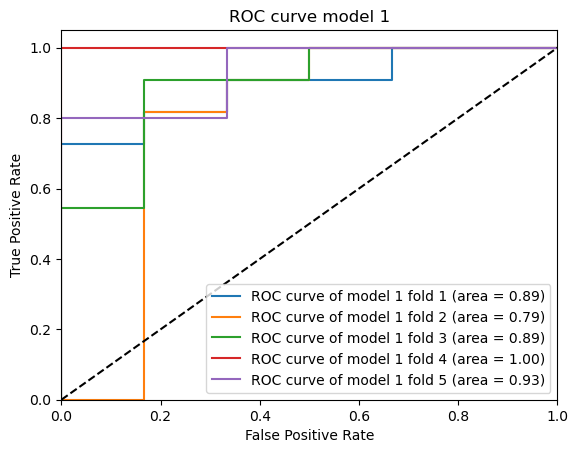

In [6]:
from sklearn.metrics import roc_curve, auc

i = 0  # 첫번째 모델 선택

# Fold 별로 반복
for j in range(skf.get_n_splits()):

    # 실제 레이블과 예측 확률을 기반으로 FPR, TPR 계산
    fpr = np.array(fpr_list_cb[i][j]).flatten()
    tpr = np.array(tpr_list_cb[i][j]).flatten()
    
    # AUC 계산
    roc_auc = auc(fpr, tpr)

    # ROC curve 그리기
    plt.plot(fpr, tpr, label=f'ROC curve of model {i+1} fold {j+1} (area = {roc_auc:0.2f})')
# 대각선 추가 (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve model 1')
plt.legend(loc="lower right")

# Plot 표시
plt.show()

In [7]:
# 데이터프레임 생성을 위한 빈 리스트 초기화
data_metrics_cb = []

# results_byth_cb 딕셔너리의 내용을 데이터프레임에 추가
for model, thresholds in results_cb.items():
    for threshold in thresholds:
        if threshold in thresholds:
            metrics = thresholds[threshold]
            accuracy = metrics['Accuracy']
            precision = metrics['Precision']
            recall = metrics['Recall']
            f1_score = metrics['F1-Score']
            auc = metrics['AUC']
        else:
            accuracy = None
            precision = None
            recall = None
            f1_score = None
            auc = None
            
        data_metrics_cb.append([model, threshold, accuracy, precision, recall, f1_score, auc])

# 데이터프레임 생성
df_metrics_cb = pd.DataFrame(data_metrics_cb, columns=['Model', 'Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score','AUC'])

df_metrics_cb

Model  Threshold  Accuracy  Precision    Recall  F1-Score       AUC
0   Model 1       0.10  0.675735   0.667081  1.000000  0.799188  0.901818
1   Model 1       0.15  0.711765   0.692670  1.000000  0.817430  0.901818
2   Model 1       0.20  0.760294   0.730437  1.000000  0.843430  0.901818
3   Model 1       0.25  0.748529   0.757739  0.923636  0.826144  0.901818
4   Model 1       0.30  0.795588   0.804788  0.923636  0.853782  0.901818
5   Model 1       0.35  0.831618   0.846653  0.923636  0.876176  0.901818
6   Model 1       0.40  0.831618   0.846653  0.923636  0.876176  0.901818
7   Model 1       0.45  0.843382   0.868998  0.905455  0.881335  0.901818
8   Model 1       0.50  0.795588   0.875260  0.812727  0.833684  0.901818
9   Model 1       0.55  0.784559   0.898232  0.756364  0.811481  0.901818
10  Model 1       0.60  0.772794   0.894661  0.738182  0.797446  0.901818
11  Model 1       0.65  0.749265   0.883232  0.701818  0.764113  0.901818

In [8]:
# 각 set 별 threshold 별 confusion matrix 출력
for i in range(num_sets):
    for idx, threshold in enumerate(thresholds):
        # Confusion Matrix 출력
        print(f"Set {sets_name[i]}, Threshold: {threshold}")
        print(results_cb[f"Model {i+1}"][threshold]["Confusion Matrix"])
        print()

# false negative들을 dictionary에 담기
false_negatives_cb = {}
for i in range(num_sets):
    for threshold in thresholds:
        if f"Model {i+1}" not in false_negatives_cb:
            false_negatives_cb[f"Model {i+1}"] = {}
        
        # False Negatives Rate 계산 및 저장
        cm = results_cb[f"Model {i+1}"][threshold]["Confusion Matrix"]
        false_negatives_rate = cm[1][0] / (cm[1][0] + cm[1][1])
        
        # False Negatives Rate를 dictionary에 저장
        false_negatives_rate_dict = {"False Negatives Rate": false_negatives_rate}
        false_negatives_cb[f"Model {i+1}"][threshold] = false_negatives_rate_dict

# 결과 확인하기
print(false_negatives_cb)


Set cb, Threshold: 0.1
[[ 3 27]
 [ 0 53]]

Set cb, Threshold: 0.15000000000000002
[[ 6 24]
 [ 0 53]]

Set cb, Threshold: 0.20000000000000004
[[10 20]
 [ 0 53]]

Set cb, Threshold: 0.25000000000000006
[[13 17]
 [ 4 49]]

Set cb, Threshold: 0.30000000000000004
[[17 13]
 [ 4 49]]

Set cb, Threshold: 0.3500000000000001
[[20 10]
 [ 4 49]]

Set cb, Threshold: 0.40000000000000013
[[20 10]
 [ 4 49]]

Set cb, Threshold: 0.45000000000000007
[[22  8]
 [ 5 48]]

Set cb, Threshold: 0.5000000000000001
[[23  7]
 [10 43]]

Set cb, Threshold: 0.5500000000000002
[[25  5]
 [13 40]]

Set cb, Threshold: 0.6000000000000002
[[25  5]
 [14 39]]

Set cb, Threshold: 0.6500000000000001
[[25  5]
 [16 37]]

{'Model 1': {0.1: {'False Negatives Rate': 0.0}, 0.15000000000000002: {'False Negatives Rate': 0.0}, 0.20000000000000004: {'False Negatives Rate': 0.0}, 0.25000000000000006: {'False Negatives Rate': 0.07547169811320754}, 0.30000000000000004: {'False Negatives Rate': 0.07547169811320754}, 0.3500000000000001: {'Fa

In [9]:
# 데이터프레임 생성을 위한 빈 리스트 초기화
data_falsenegative_cb = []

# false_negatives_cb 딕셔너리의 내용을 데이터프레임에 추가
for model, thresholds in false_negatives_cb.items():
    for threshold, metrics in thresholds.items():
        false_neg_rate = metrics['False Negatives Rate']
        data_falsenegative_cb.append([model, threshold, false_neg_rate])

# 데이터프레임 생성
df_false_negatives_cb = pd.DataFrame(data_falsenegative_cb, columns=['Model', 'Threshold', 'False Negatives Rate'])

# 출력
df_false_negatives_cb

Model  Threshold  False Negatives Rate
0   Model 1       0.10              0.000000
1   Model 1       0.15              0.000000
2   Model 1       0.20              0.000000
3   Model 1       0.25              0.075472
4   Model 1       0.30              0.075472
5   Model 1       0.35              0.075472
6   Model 1       0.40              0.075472
7   Model 1       0.45              0.094340
8   Model 1       0.50              0.188679
9   Model 1       0.55              0.245283
10  Model 1       0.60              0.264151
11  Model 1       0.65              0.301887

In [10]:
# df_false_negatives와 df_byth_cb 합치기 (outer join)
df_combined_cb = pd.merge(df_false_negatives_cb, df_metrics_cb, on=["Model", "Threshold"],how="outer")

# 출력
df_combined_cb


Model  Threshold  False Negatives Rate  Accuracy  Precision    Recall  \
0   Model 1       0.10              0.000000  0.675735   0.667081  1.000000   
1   Model 1       0.15              0.000000  0.711765   0.692670  1.000000   
2   Model 1       0.20              0.000000  0.760294   0.730437  1.000000   
3   Model 1       0.25              0.075472  0.748529   0.757739  0.923636   
4   Model 1       0.30              0.075472  0.795588   0.804788  0.923636   
5   Model 1       0.35              0.075472  0.831618   0.846653  0.923636   
6   Model 1       0.40              0.075472  0.831618   0.846653  0.923636   
7   Model 1       0.45              0.094340  0.843382   0.868998  0.905455   
8   Model 1       0.50              0.188679  0.795588   0.875260  0.812727   
9   Model 1       0.55              0.245283  0.784559   0.898232  0.756364   
10  Model 1       0.60              0.264151  0.772794   0.894661  0.738182   
11  Model 1       0.65              0.301887  0.749265   0.883232  0.701818   

    F1-Score       AUC  
0   0.799188  0.901818  
1   0.817430  0.901818  
2   0.843430  0.901818  
3   0.826144  0.901818  
4   0.853782  0.901818  
5   0.876176  0.901818  
6   0.876176  0.901818  
7   0.881335  0.901818  
8   0.833684  0.901818  
9   0.811481  0.901818  
10  0.797446  0.901818  
11  0.764113  0.901818

In [11]:
# CSV 파일로 저장
df_combined_cb.to_csv('df_combined_cb.csv', index=False)


## XAI

In [ ]:
# from pdpbox import pdp

# for i in range(num_sets):
#     model = cat_classifiers[i]  # 첫 번째 데이터셋에 대해 학습된 모델
    
#     print('-----------------------------------------------------------------------------------------')
#     print(X_dataset_names[i],'에 대한 PDPplot')

#     for j in range(len(col_name_sets[i])):
#         # 각 column별 PDP 생성
#         pdp_goals = pdp.pdp_isolate(model=model, dataset=X_sets[i], model_features=X_sets[i].columns.tolist(), feature=col_name_sets[i][j])

#         # PDP 그리기
#         pdp.pdp_plot(pdp_goals, col_name_sets[i][j])
#         plt.show()

-----------------------------------------------------------------------------------------
X_cb 에 대한 PDPplot


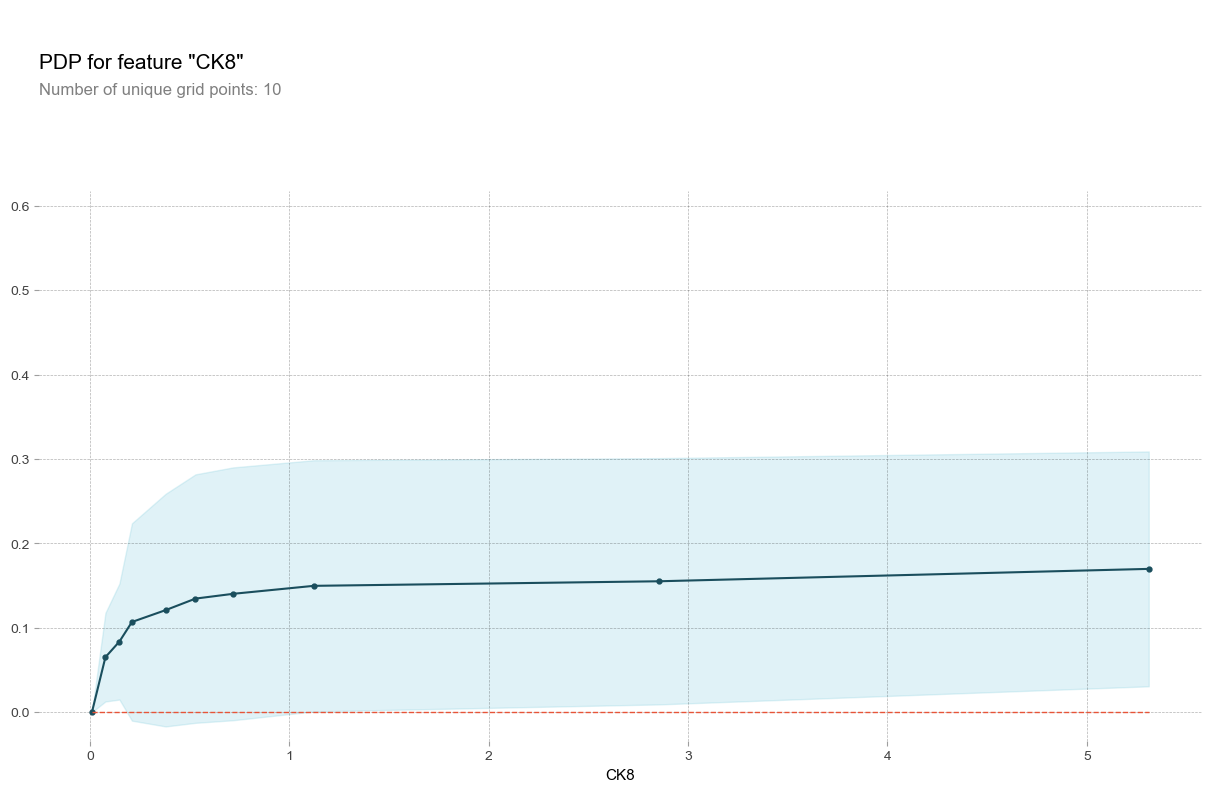

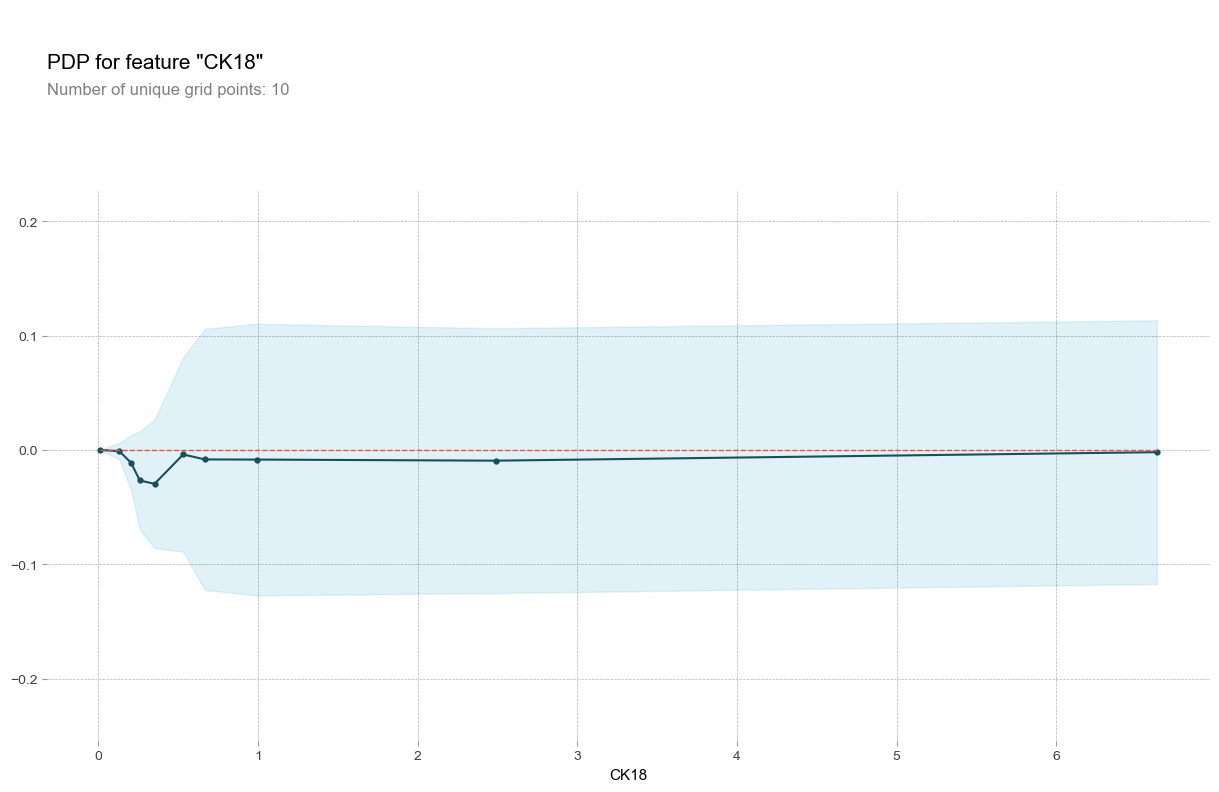

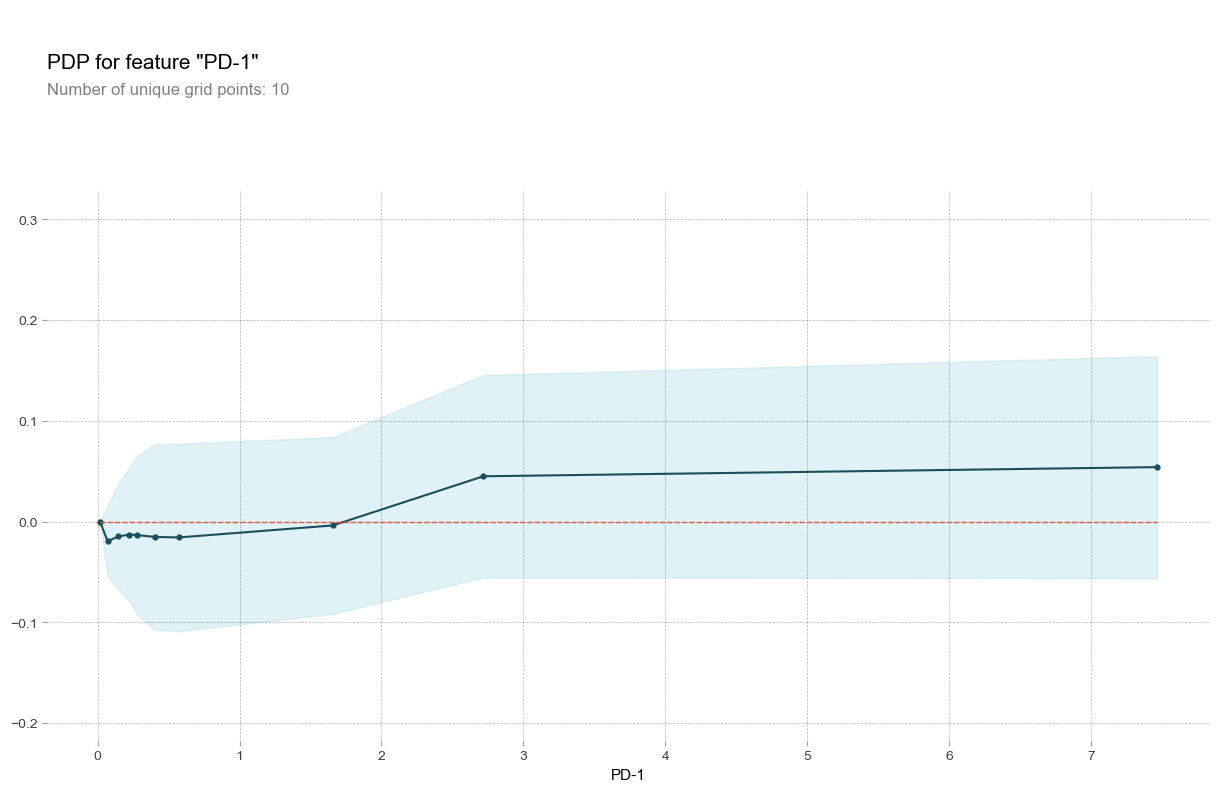

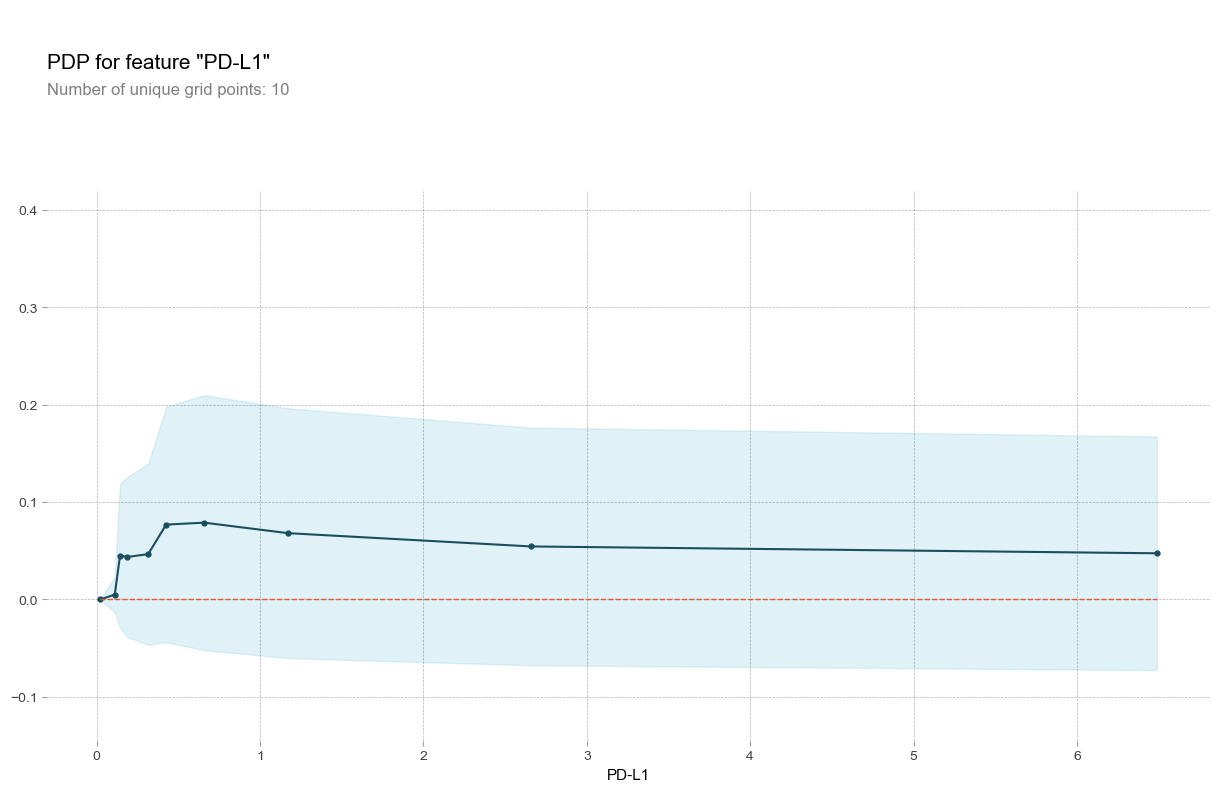

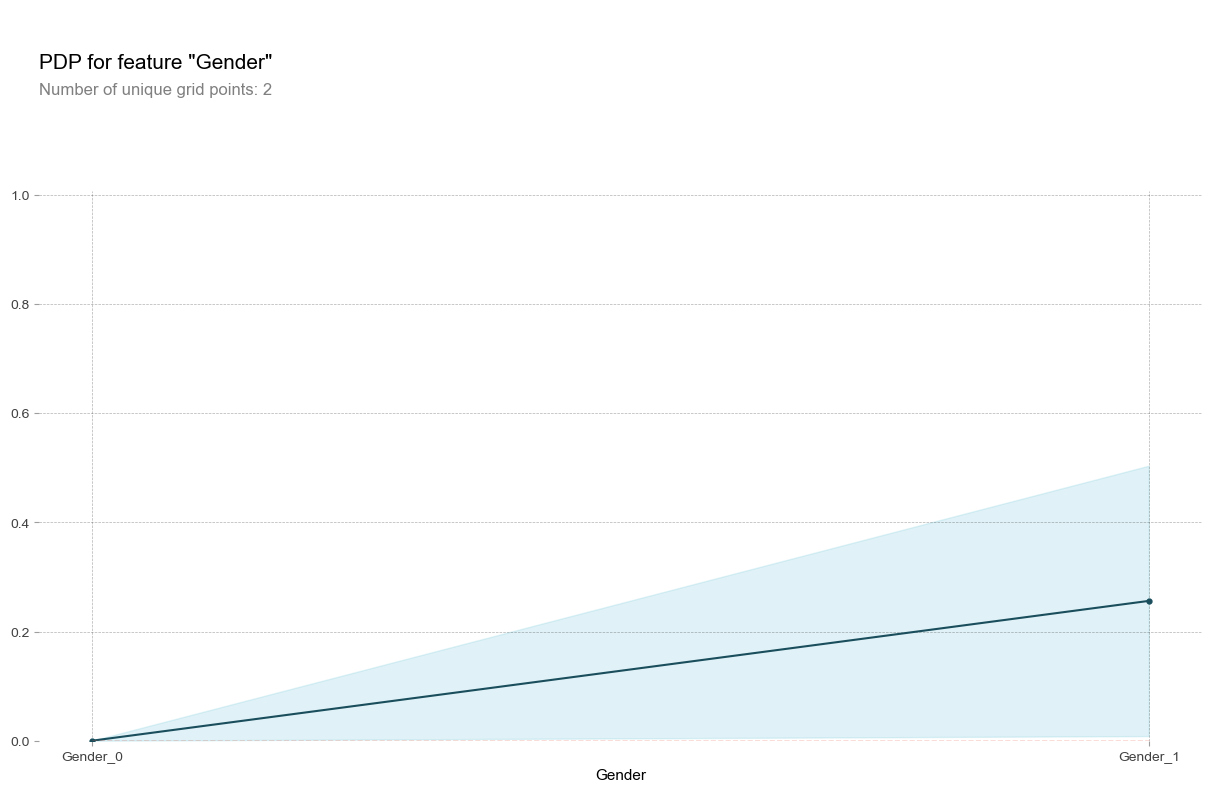

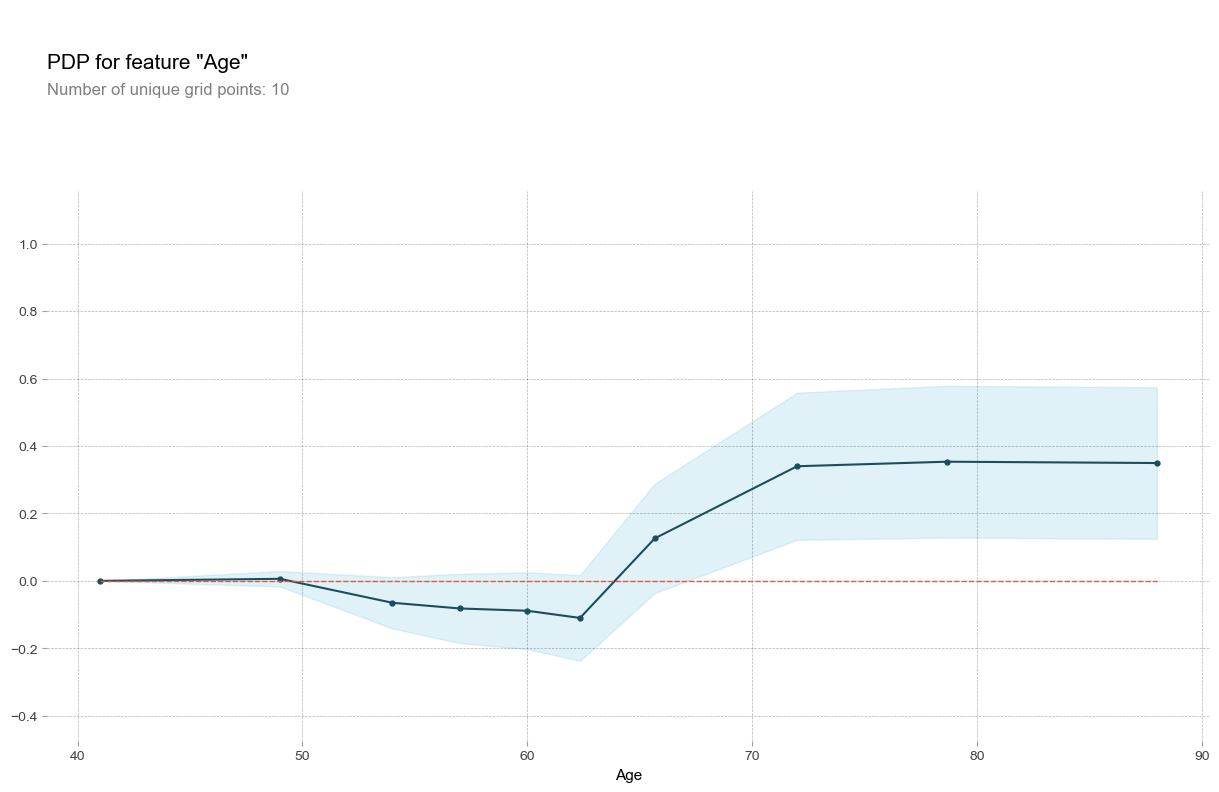

In [12]:
from pdpbox import pdp

for i in range(num_sets):
    model = cb_classifiers[i]
    
    print('-----------------------------------------------------------------------------------------')
    print(X_dataset_names[i],'에 대한 PDPplot')

    for j in range(len(col_name_sets[i])):
        # 각 column별 PDP 생성
        pdp_goals = pdp.pdp_isolate(model=model, dataset=X_sets[i], model_features=X_sets[i].columns.tolist(), feature=col_name_sets[i][j])
        
        # Create a DataFrame from the data stored in the pdp_goals object
        df_pdp = pd.DataFrame({'feature_values': pdp_goals.feature_grids, 'partial_dependence': pdp_goals.pdp})

        # To save it as csv file:
        df_pdp.to_csv(f'./cb_pdp/{X_dataset_names[i]}_{col_name_sets[i][j]}.csv', index=False)

        # PDP 그리기
        pdp.pdp_plot(pdp_goals, col_name_sets[i][j])
        plt.show()